In [1]:
import ugradio
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
import dish
import cartopy.crs as ccrs
from scipy.interpolate import interp2d
from tqdm import tqdm, trange
%matplotlib inline

No module named 'rtlsdr'


In [2]:
gal_b = []
gal_l = []
bs = np.arange(-70, -8, 4)
for b in bs:
    ls = np.arange(160, 220.1, 4/np.cos(b*np.pi/180))
    for l in ls:
        np.array(gal_b.append(b))
        np.array(gal_l.append(l))

In [8]:
len(dish.bubble_coords())

697

In [9]:
x, y = np.meshgrid(gal_l, gal_b)

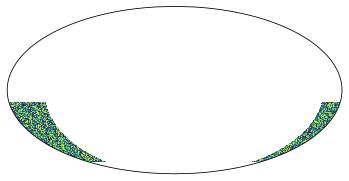

In [10]:
fig, ax = plt.subplots(subplot_kw={'projection':ccrs.Mollweide()})

temp=np.random.rand(len(x),len(y)) #replace with real data
ax.imshow(temp,extent=[160,220,-70,-10], transform=ccrs.PlateCarree())

#TO-DO: rotate and crop

plt.grid()
plt.show()

In [11]:
def calibrate(data_nd0, data_nd1, pol):
    diff = np.array(data_nd1) - np.array(data_nd0)
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

def calibrate1(data_nd0, data_nd1, pol):
    diff = np.median(np.array(data_nd1) - np.array(data_nd0))
    if pol == 0:
        T = 90
    elif pol == 1:
        T = 65
    else: print('Bruh its literally either a 0 or 1 you cant fuck it up')
    G = T/diff
    t_line = G * data_nd0
    return t_line

In [12]:
nfiles = 697
nfreq = 8192

In [13]:
nspec = 50

list_0 = np.empty((nfiles, nspec, nfreq))
list_1 = np.empty((nfiles, nspec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd0.fits')
    
    for j in range(nspec):
        
        list_0[i,j] = f[j+1].data['auto0_real']
        
        list_1[i,j] = f[j+1].data['auto1_real']

100%|██████████| 697/697 [02:26<00:00,  4.74it/s]


In [14]:
noise_spec = 5

noise_0 = np.empty((nfiles, noise_spec, nfreq))
noise_1 = np.empty((nfiles, noise_spec, nfreq))

for i in trange(nfiles):
    
    f = fits.open(f'lab4_data/{i}_nd1.fits')
    
    for j in range(noise_spec):
        
        noise_0[i,j] = f[j+1].data['auto0_real']
        
        noise_1[i,j] = f[j+1].data['auto1_real']

 70%|███████   | 489/697 [00:11<00:04, 44.00it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'lab4_data/489_nd1.fits'

In [15]:
mean_specs_0 = np.mean(list_0, axis=1)
mean_specs_1 = np.mean(list_1, axis=1)

In [16]:
median_specs_0 = np.median(list_0, axis=1)
median_specs_1 = np.median(list_1, axis=1)

In [17]:
mean_noise_0 = np.mean(noise_0, axis=1)
mean_noise_1 = np.mean(noise_1, axis=1)

In [18]:
median_noise_0 = np.median(noise_0, axis=1)
median_noise_1 = np.median(noise_1, axis=1)

In [30]:
tline_0 = calibrate(mean_specs_0, mean_noise_0, 0)
tline_1 = calibrate(mean_specs_1, mean_noise_1, 1)

<ipython-input-11-1661aa92e76a>:8: RuntimeWarning: divide by zero encountered in true_divide
  G = T/diff
<ipython-input-11-1661aa92e76a>:9: RuntimeWarning: invalid value encountered in multiply
  t_line = G * data_nd0


In [20]:
Tline_0 = calibrate1(median_specs_0, median_noise_0, 0)
Tline_1 = calibrate1(median_specs_1, median_noise_1, 1)
Tline_0.shape

(697, 8192)

In [21]:
ctline_0 = np.empty((nfiles, nfreq))
ctline_1 = np.empty((nfiles, nfreq))

for i in trange(nfiles):
    sub_0 = Tline_0[i] - np.mean(Tline_0[i])
    ctline_0[i] = sub_0
    sub_1 = Tline_1[i] - np.mean(Tline_1[i])
    ctline_1[i] = sub_1

100%|██████████| 697/697 [00:00<00:00, 6993.48it/s]


In [22]:
T_0 = np.max(ctline_0, axis=1)
T_1 = np.max(ctline_1, axis=1)

# interpolation attempt

In [3]:
coords = np.array(dish.bubble_coords())
cond = np.abs(coords) > 400
coords[cond] == 0 
coords_trunc = coords[cond]

In [120]:
coords_trunc = coords[:,1] < 300

True

In [104]:
x = coords_trunc[:,0]
y = coords_trunc[:,1]

In [119]:
np.where(False, [x,y])

ValueError: either both or neither of x and y should be given

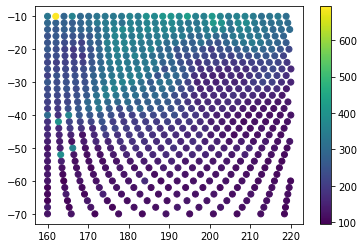

In [102]:

np.shape(coords)
plt.scatter(coords[:,0], coords[:,1], c=T_0)
#plt.scatter(x,y,alpha=0.5)
plt.colorbar()

array([177.25655588, -22.        ])

In [1]:
# maybe we need to filter out the high temperature points? need help with the best way to do that though!!

In [62]:
np.shape(t_interp)

(10000, 10000)

In [78]:
grid = np.meshgrid(np.linspace(160,220,200), np.linspace(-70,-10,200))

In [79]:
spline = interp2d(coords[:,0], coords[:,1], T_0, kind = 'linear')
t_interp = spline(grid[0].flatten(), grid[1].flatten())

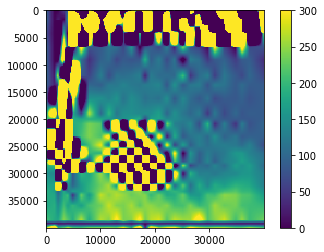

In [80]:
im = plt.imshow(t_interp)
im.set_clim(0,300)
#plt.scatter(x,y,alpha=0.5)
plt.colorbar()

Text(0.5, 0.98, 'Test Data Power Spectra')

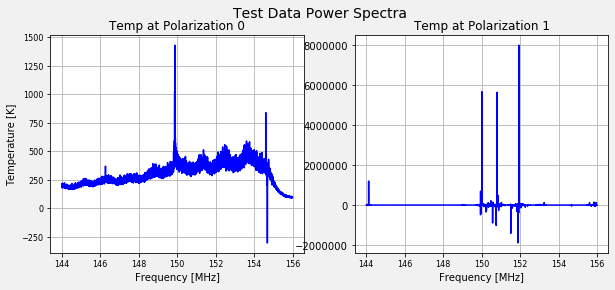

In [11]:
freq = np.linspace(144,156,8192)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,4), facecolor='#f1f1f1')

ax1.plot(freq, tline_0[200], color='b')
ax1.set_title('Temp at Polarization 0', fontsize=12)
ax1.set_xlabel('Frequency [MHz]', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_ylabel('Temperature [K]', fontsize=10)
ax1.grid()

ax2.plot(freq, tline_1[200], color='b')
ax2.set_title('Temp at Polarization 1', fontsize=12)
ax2.set_xlabel('Frequency [MHz]')
ax2.xaxis.set_tick_params(labelsize=8)
ax2.grid()

fig.suptitle('Test Data Power Spectra', fontsize=14)

Text(0.5, 0.98, 'Test Data Power Spectra')

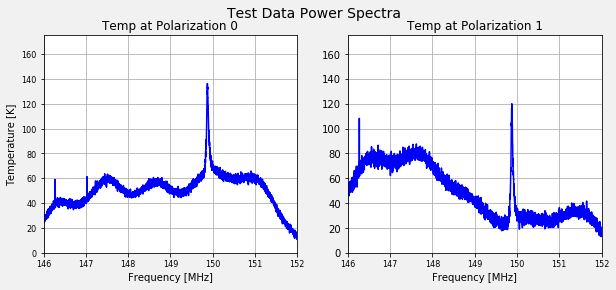

In [12]:
freq = np.linspace(144,156,8192)

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10,4), facecolor='#f1f1f1')

ax1.plot(freq, Tline_0[200]-Tline_0[200].mean(), color='b')
ax1.set_title('Temp at Polarization 0', fontsize=12)
ax1.set_xlabel('Frequency [MHz]', fontsize=10)
ax1.xaxis.set_tick_params(labelsize=8)
ax1.yaxis.set_tick_params(labelsize=8)
ax1.set_ylabel('Temperature [K]', fontsize=10)
ax1.grid()

ax2.plot(freq, Tline_1[200]-Tline_1[200].mean(), color='b')
ax2.set_title('Temp at Polarization 1', fontsize=12)
ax2.set_xlabel('Frequency [MHz]')
ax2.xaxis.set_tick_params(labelsize=8)
ax2.grid()

for ax in ax1, ax2:
    ax.set_ylim(0, 175)
    ax.set_xlim(146, 152)

fig.suptitle('Test Data Power Spectra', fontsize=14)

In [ ]:
T = 

# attempt at calibrating around small, flat region...

In [29]:
plt.plot(freq, tline_0[200])
plt.xlim(146.5,148.5)
plt.ylim(150,350)
plt.grid()
plt.show()

NameError: name 'freq' is not defined

In [35]:
F_low = 146.5
F_high = 148.5
spec = tline_0[200]
freq = np.linspace(144,156,8192)

condition = (freq >= F_low) * (freq <= F_high)
trunc_spec = spec[condition]
trunc_freq = freq[condition]

In [39]:
trunc_spectra = tline_0[:, condition]

attempted to replicate the conditional arguments Christian helped me pass lab 3's Fourier Filter through but either the strategy is naive or the execution is

<function matplotlib.pyplot.show(*args, **kw)>

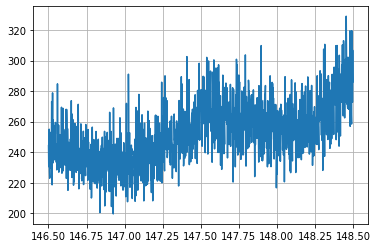

In [37]:
plt.plot(trunc_freq,trunc_spec)
plt.grid()
plt.show

In [43]:
np.polyfit(trunc_freq,trunc_spec, 2)

array([ 4.67252761e+00, -1.35884463e+03,  9.90235562e+04])

In [45]:
calibration_fit = 4.67252761e+00*(trunc_freq)**2 + -1.35884463e+03*(trunc_freq) + 9.90235562e+04

<function matplotlib.pyplot.show(*args, **kw)>

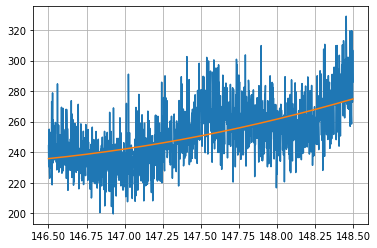

In [46]:
plt.plot(trunc_freq,trunc_spec)
plt.plot(trunc_freq, calibration_fit)
plt.grid()
plt.show